# Select best model, DAR and save regions

After the job to run models is done, load the model and cistopic_obj

In [1]:
import os
import warnings
import pandas as pd
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
import pickle
warnings.simplefilter(action='ignore')

In [2]:
# Project and output directories
projDir = '/data/niecr/cheongj/misc/results_seurat/scenicplus/'
out_dir = os.path.join(projDir, 'output/')
tmpDir = '/scratch/ramaiar1/'
# Base directory for cellranger outputs
base_dir = '/data/niecr/cheongj/misc/cellranger_outs'
# Load cell data
cell_data = pd.read_csv("/data/niecr/cheongj/misc/results_seurat/metadata/02_misc_merged_all.csv")

In [4]:
cistopic_obj = pickle.load(open(os.path.join(out_dir, "merged_cistopic_obj.pkl"), "rb"))
models = pickle.load(open(os.path.join(out_dir, "models.pkl"), "rb"))

In [7]:
models

# Model selection

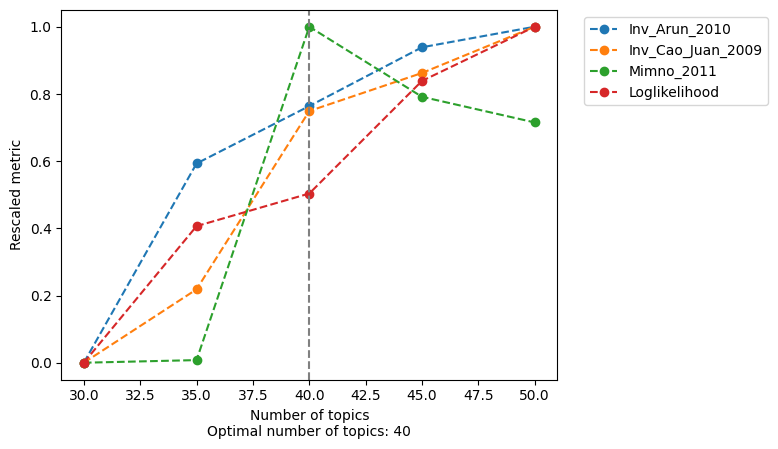

In [14]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(
    models,
    select_model = 40,
    return_model = True
)

In [15]:
cistopic_obj.add_LDA_model(model)

In [16]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

# Clustering and visualization

In [6]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)

In [8]:
find_clusters(
    cistopic_obj,
    target  = 'cell',
    k = 10,
    res = [0.6, 1.2, 3],
    prefix = 'pycisTopic_',
    scale = True,
    split_pattern = '-'
)

2024-12-26 16:11:55,284 cisTopic     INFO     Finding neighbours


In [9]:
run_umap(
    cistopic_obj,
    target  = 'cell', scale=True)

2024-12-26 16:13:40,452 cisTopic     INFO     Running UMAP


In [20]:
run_tsne(
    cistopic_obj,
    target  = 'cell', scale=True)

2024-12-26 14:05:56,937 cisTopic     INFO     Running TSNE


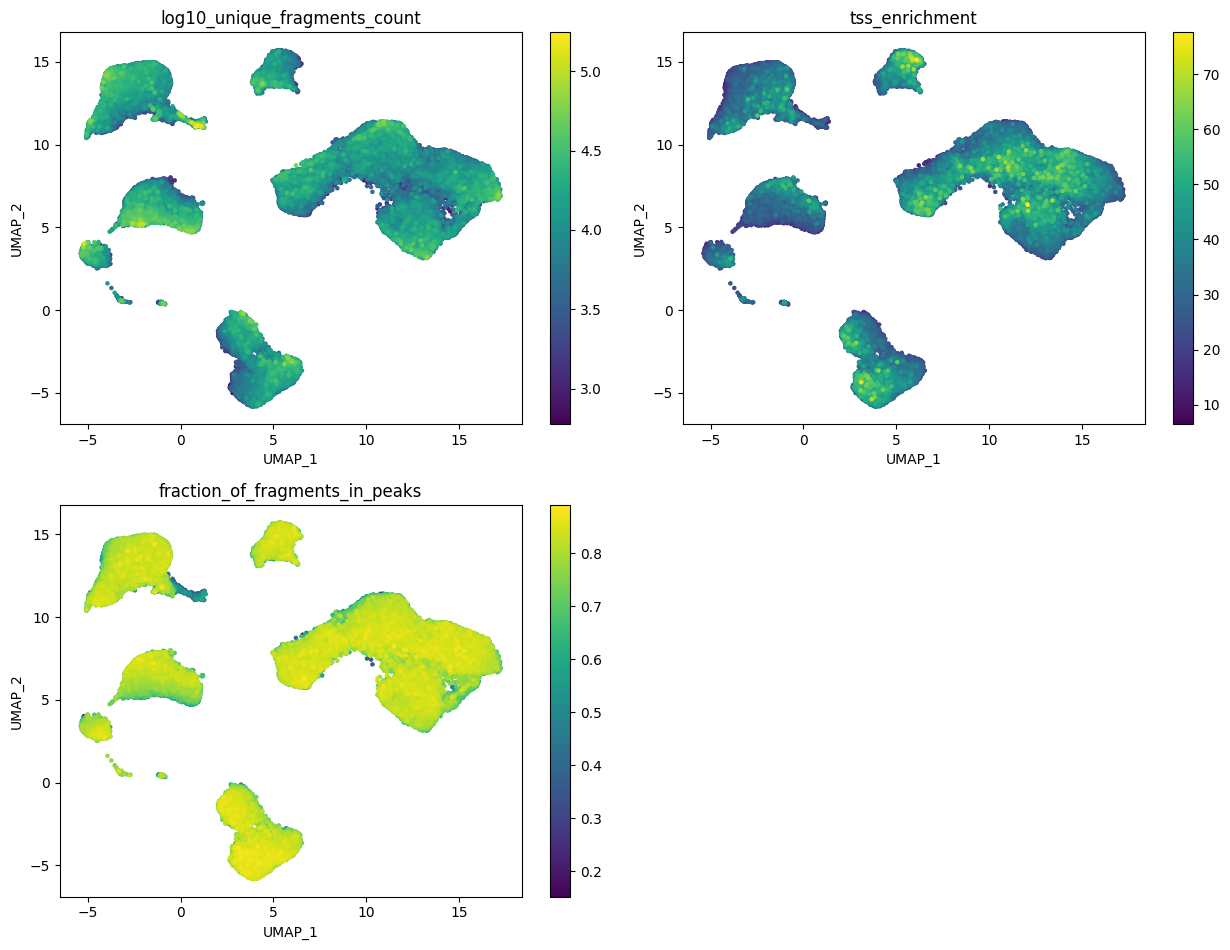

In [10]:
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['log10_unique_fragments_count', 'tss_enrichment', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=2,
    text_size=10,
    dot_size=5)

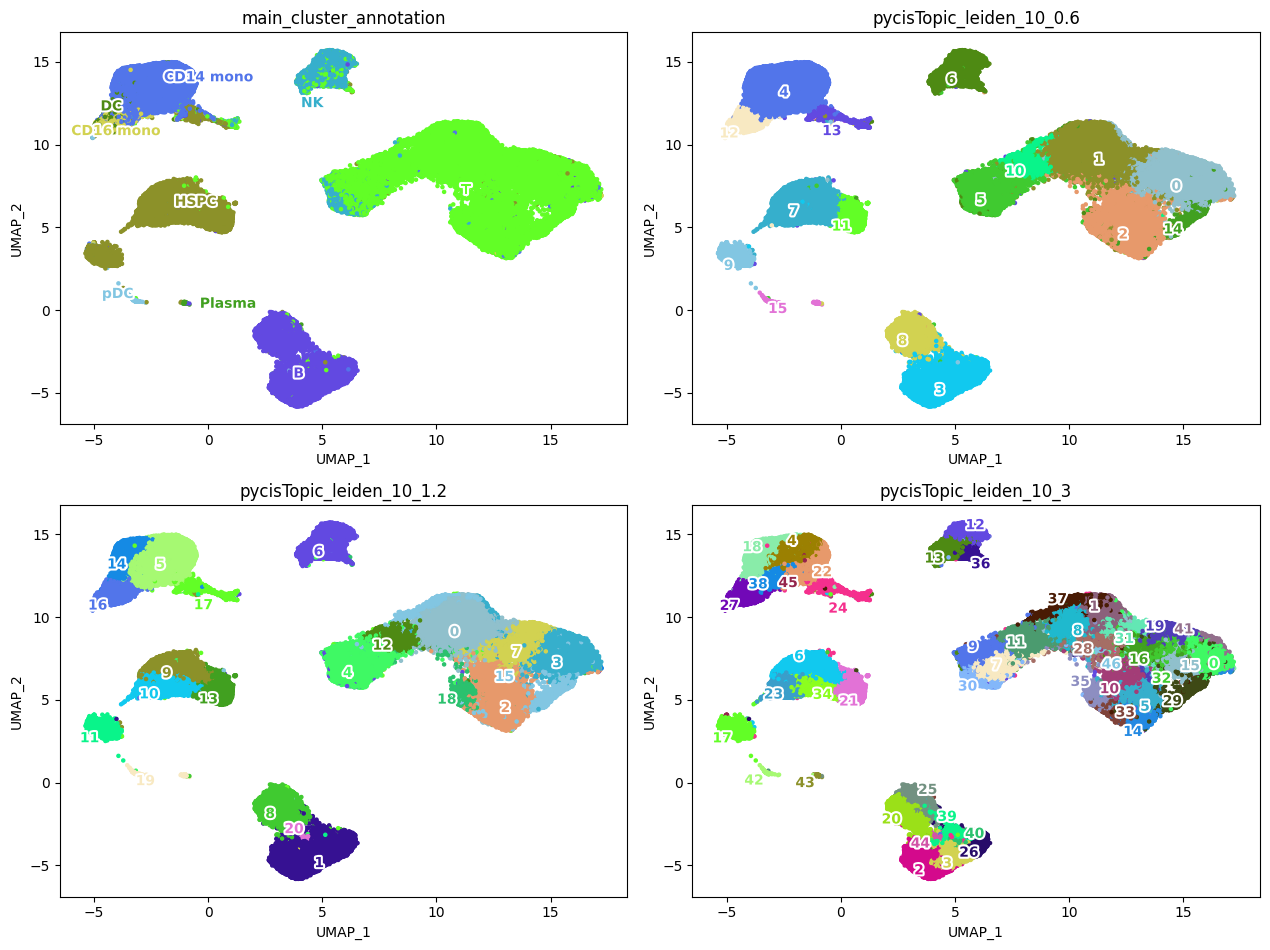

In [11]:
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['main_cluster_annotation', 'pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2', 'pycisTopic_leiden_10_3'],
    target='cell', num_columns=2,
    text_size=10,
    dot_size=5)

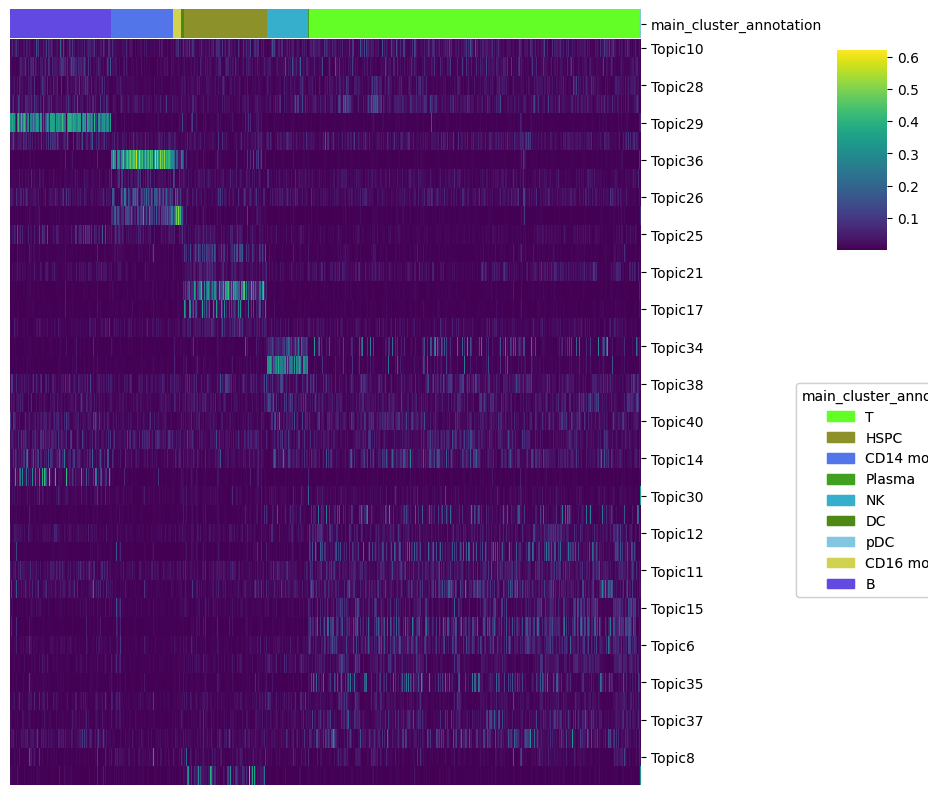

In [12]:
cell_topic_heatmap(
    cistopic_obj,
    variables = ['main_cluster_annotation'],
    scale = False,
    legend_loc_x = 1.0,
    legend_loc_y = -1.2,
    legend_dist_y = -1,
    figsize = (10, 10)
)

In [13]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

# Topic binarization & QC

In [ ]:
cistopic_obj = pickle.load(open(os.path.join(out_dir, "cistopic_obj.pkl"), "rb"))

In [14]:
from pycisTopic.topic_binarization import binarize_topics

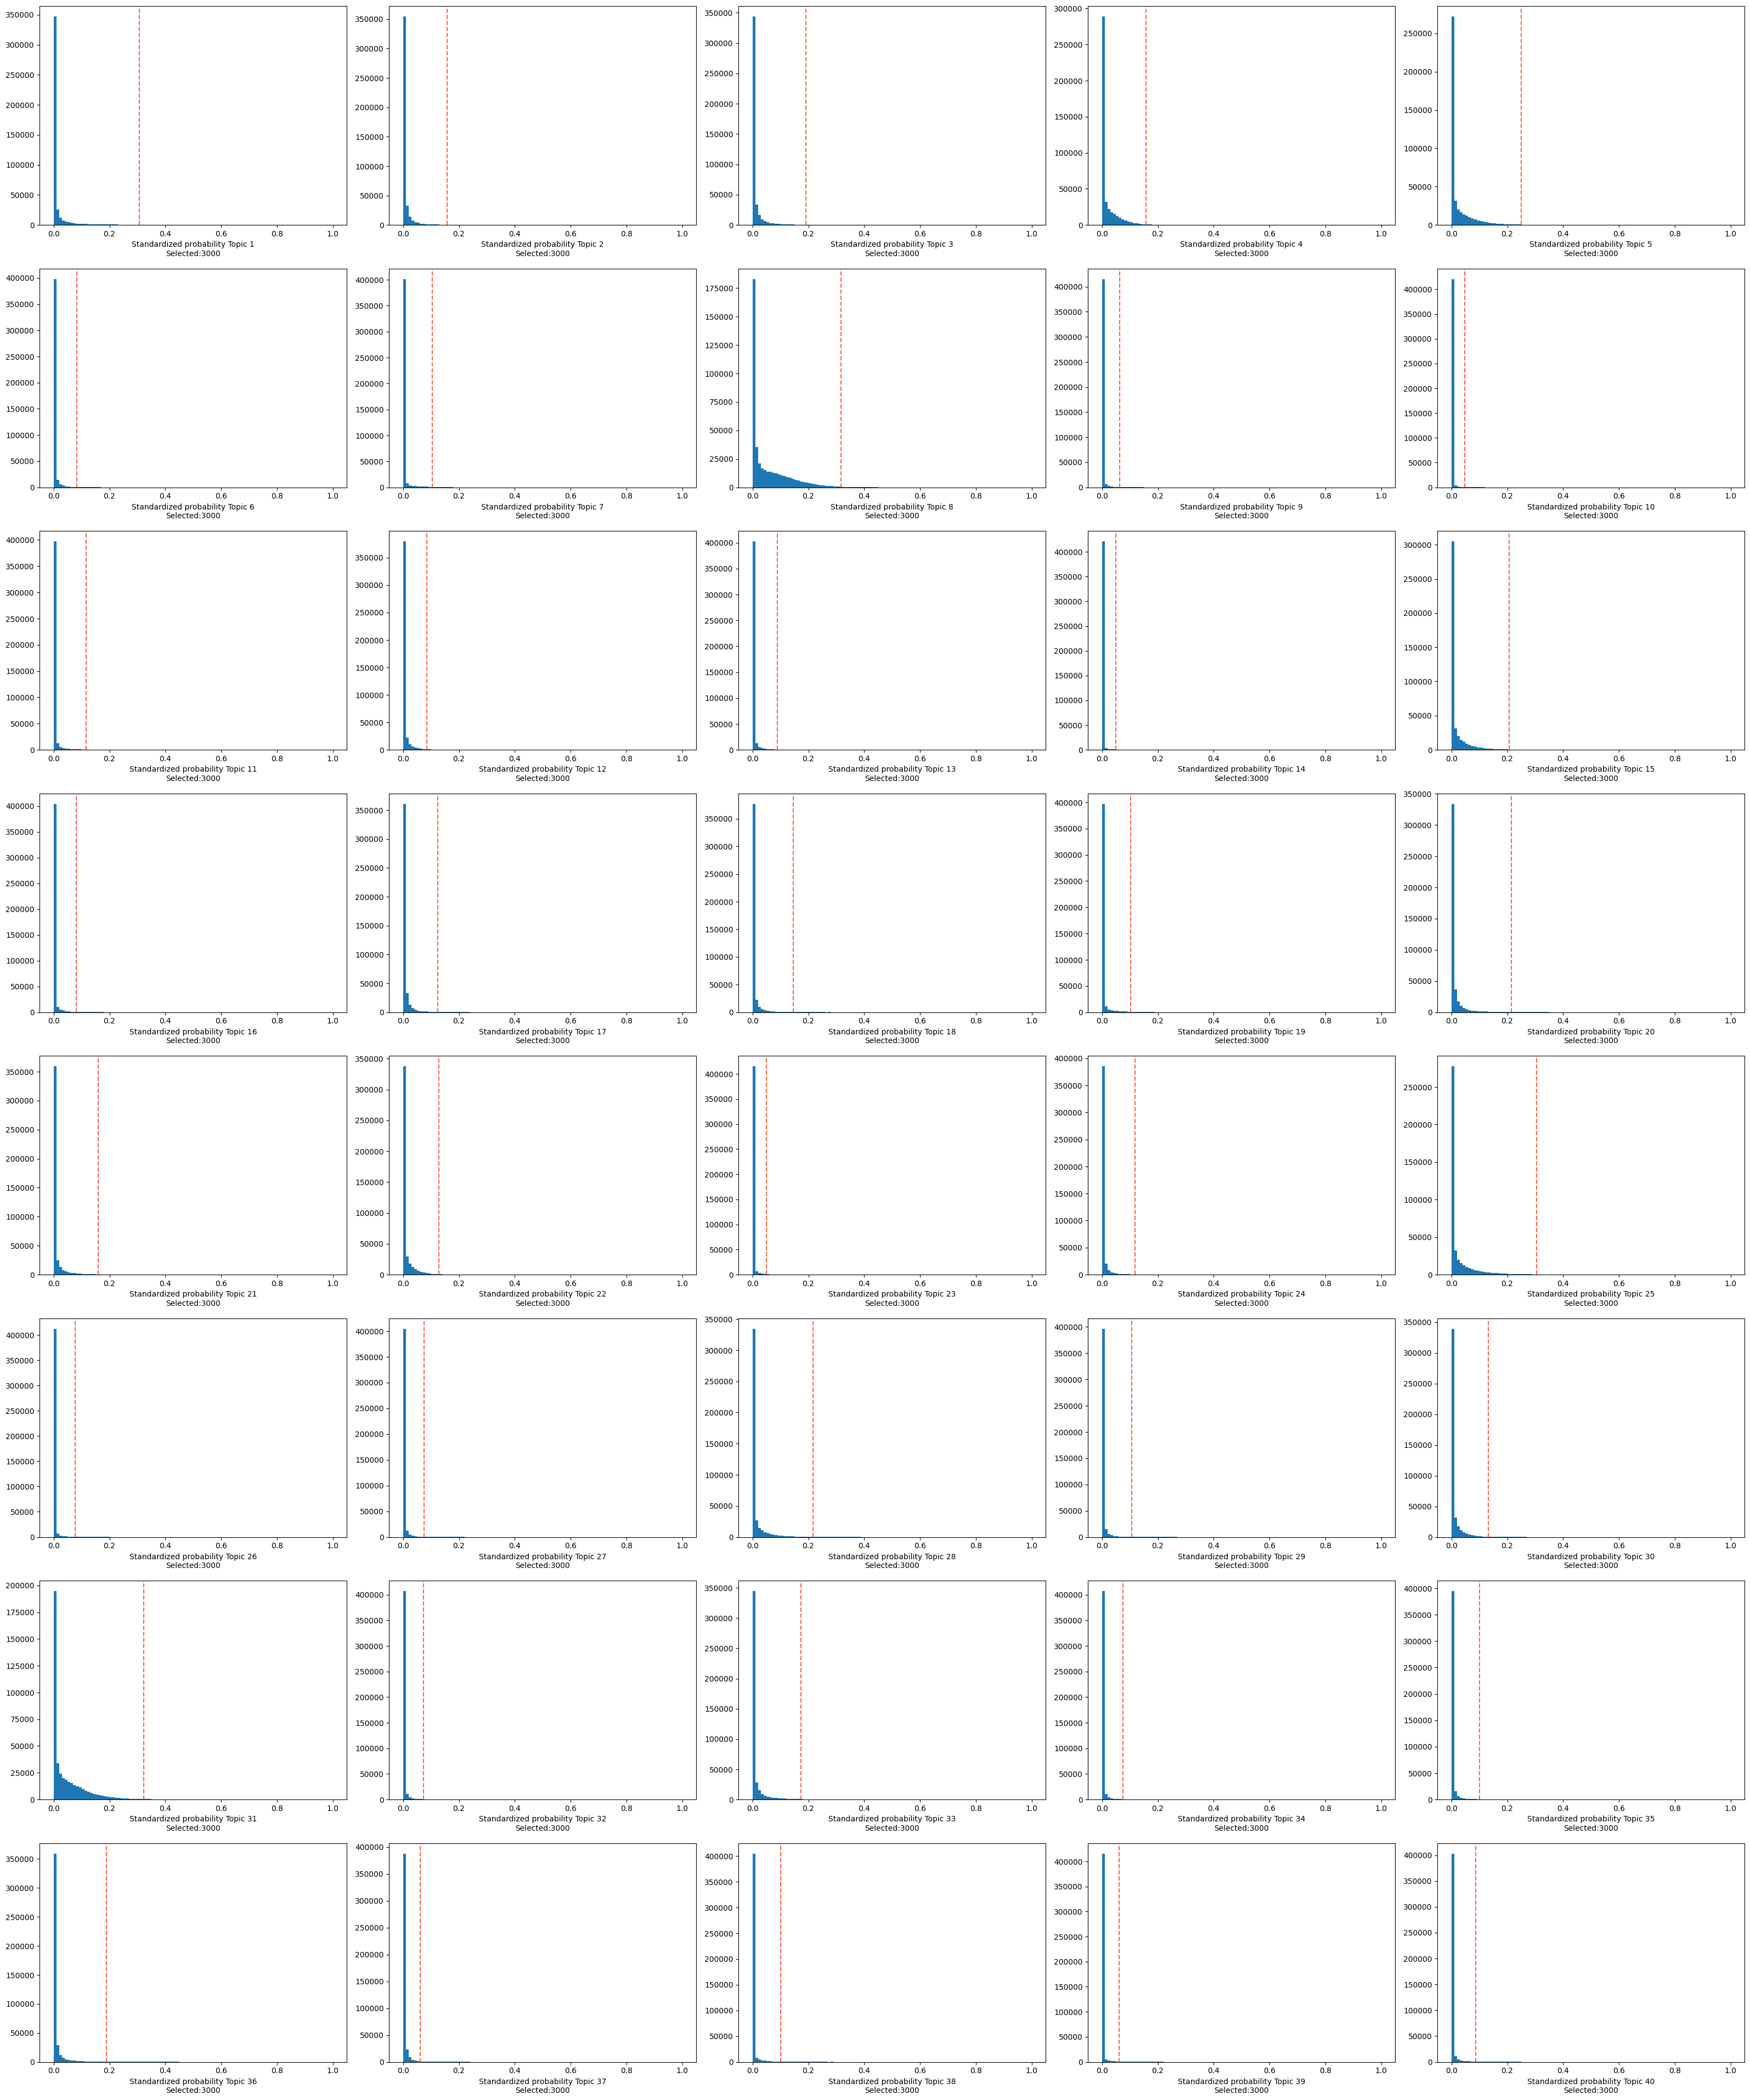

In [15]:
region_bin_topics_top_3k = binarize_topics(
    cistopic_obj, method='ntop', ntop = 3_000,
    plot=True, num_columns=5
)

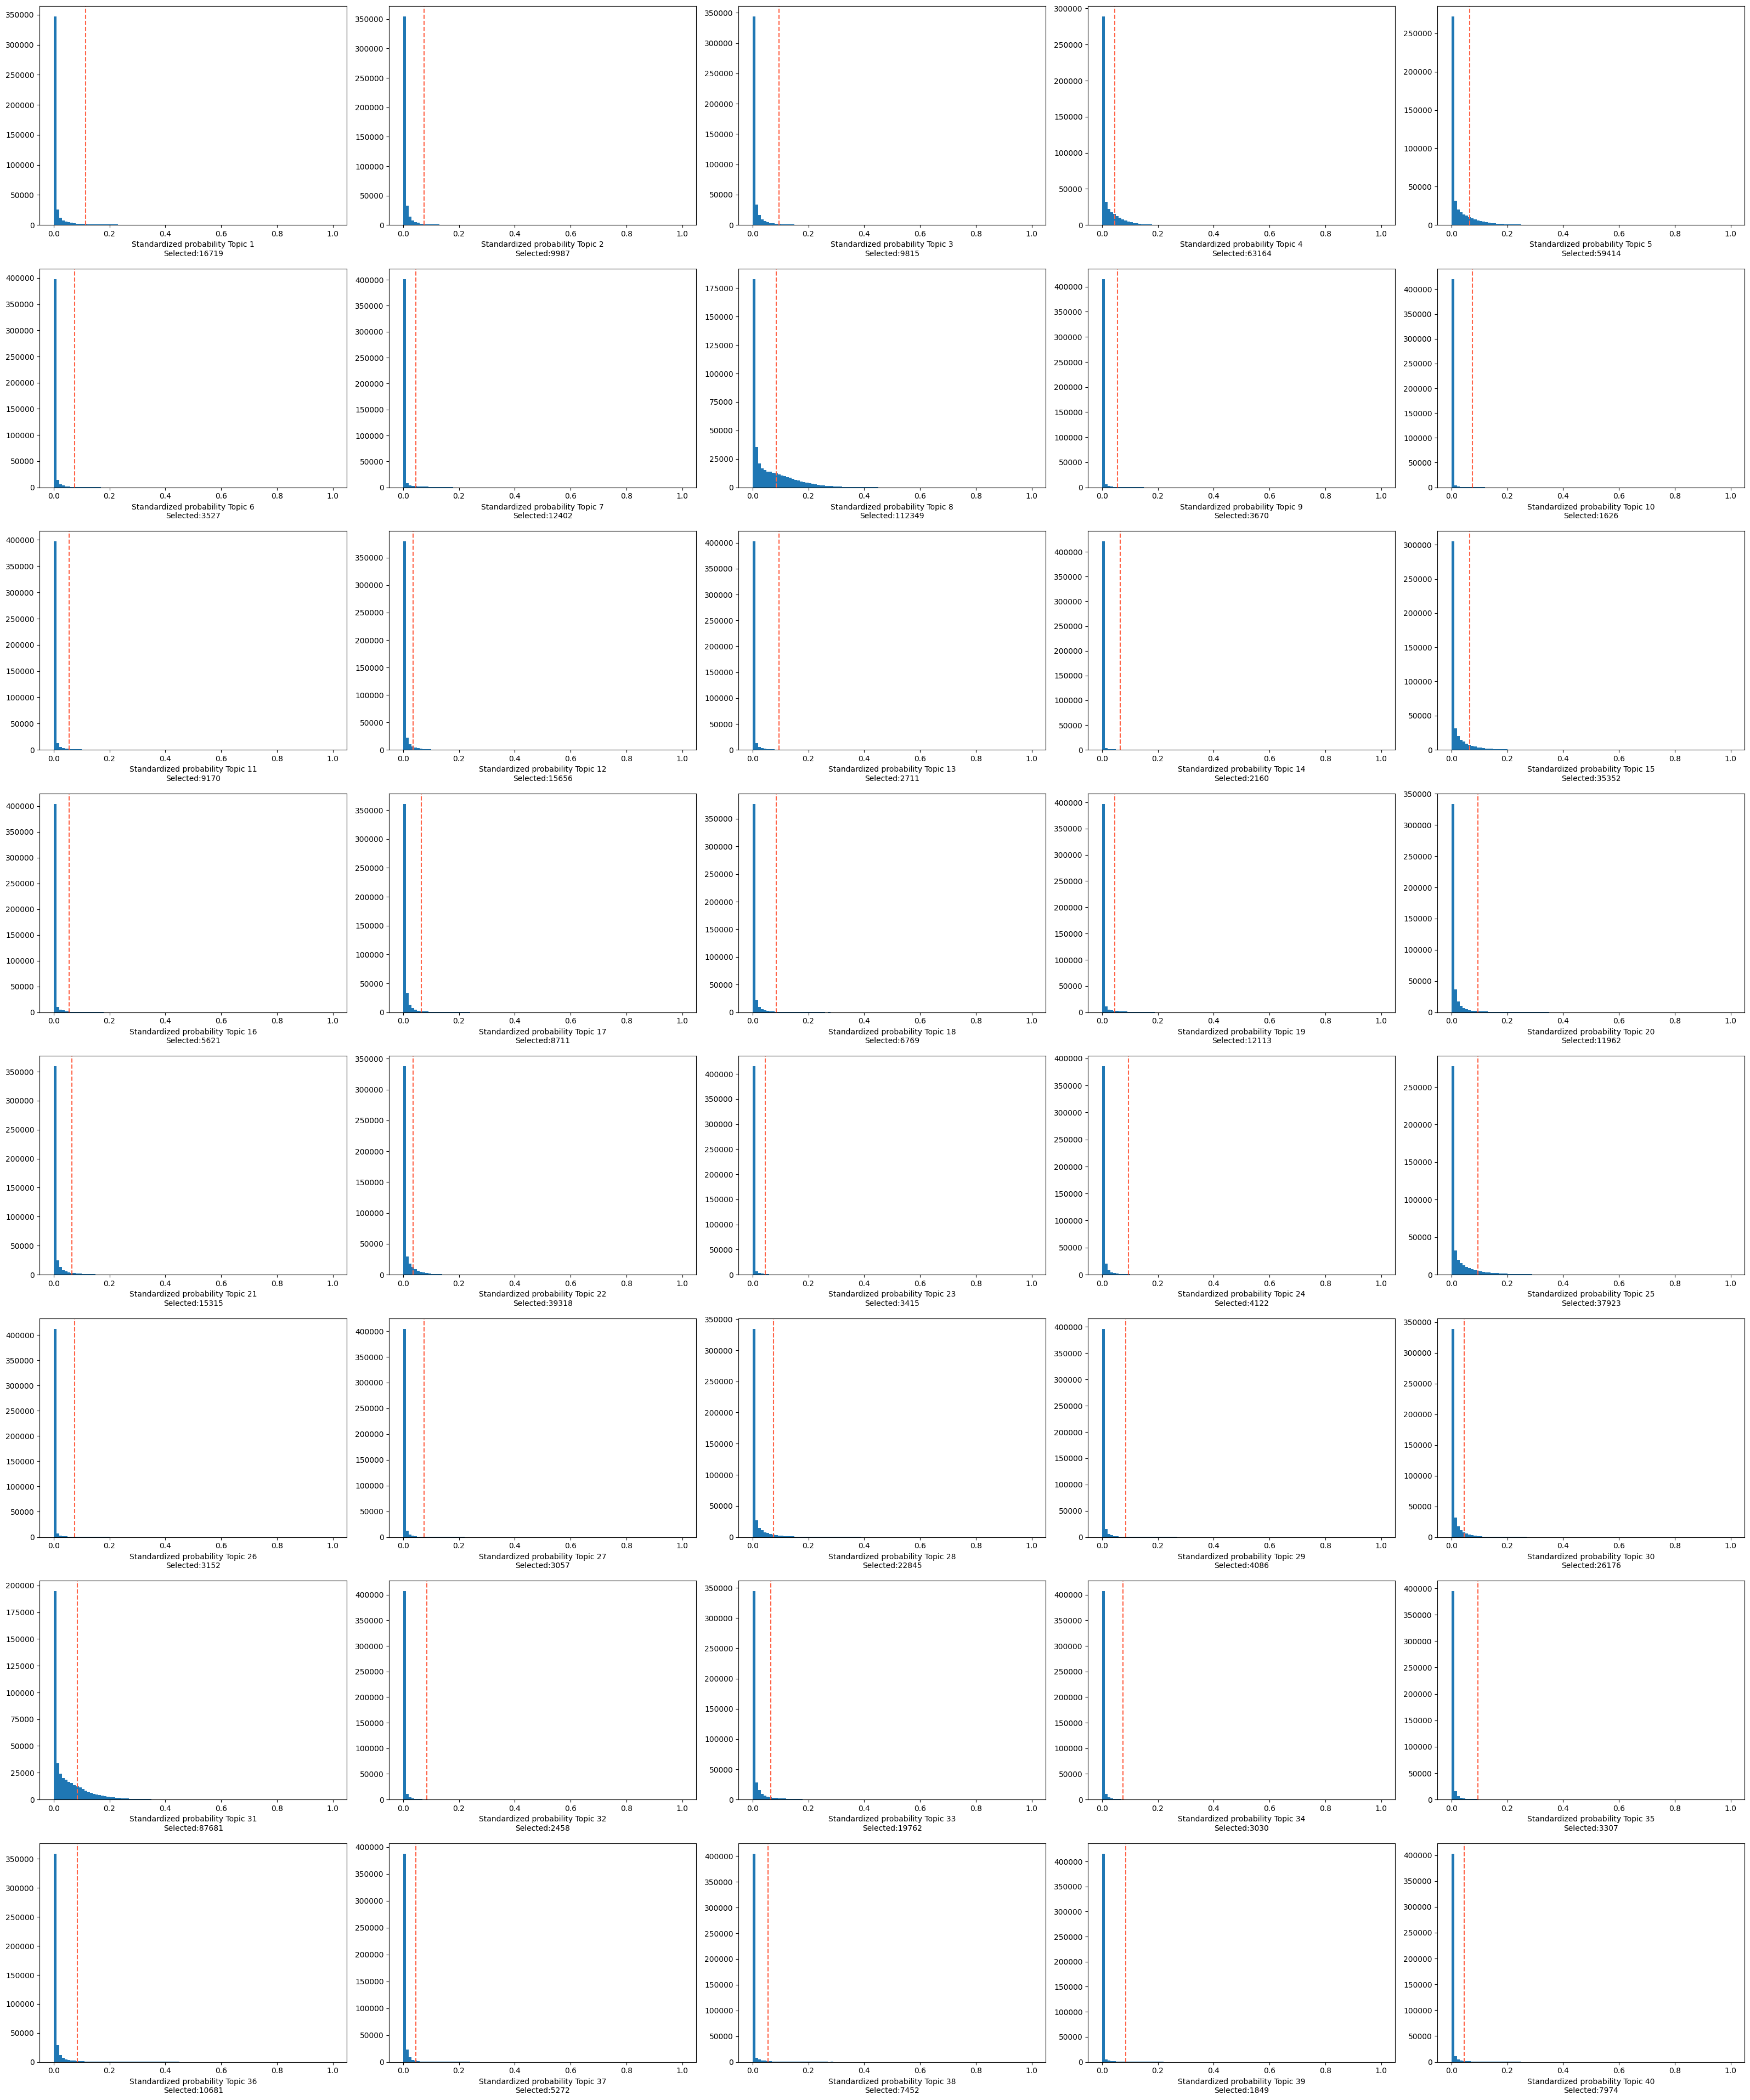

In [16]:
region_bin_topics_otsu = binarize_topics(
    cistopic_obj, method='otsu',
    plot=True, num_columns=5
)

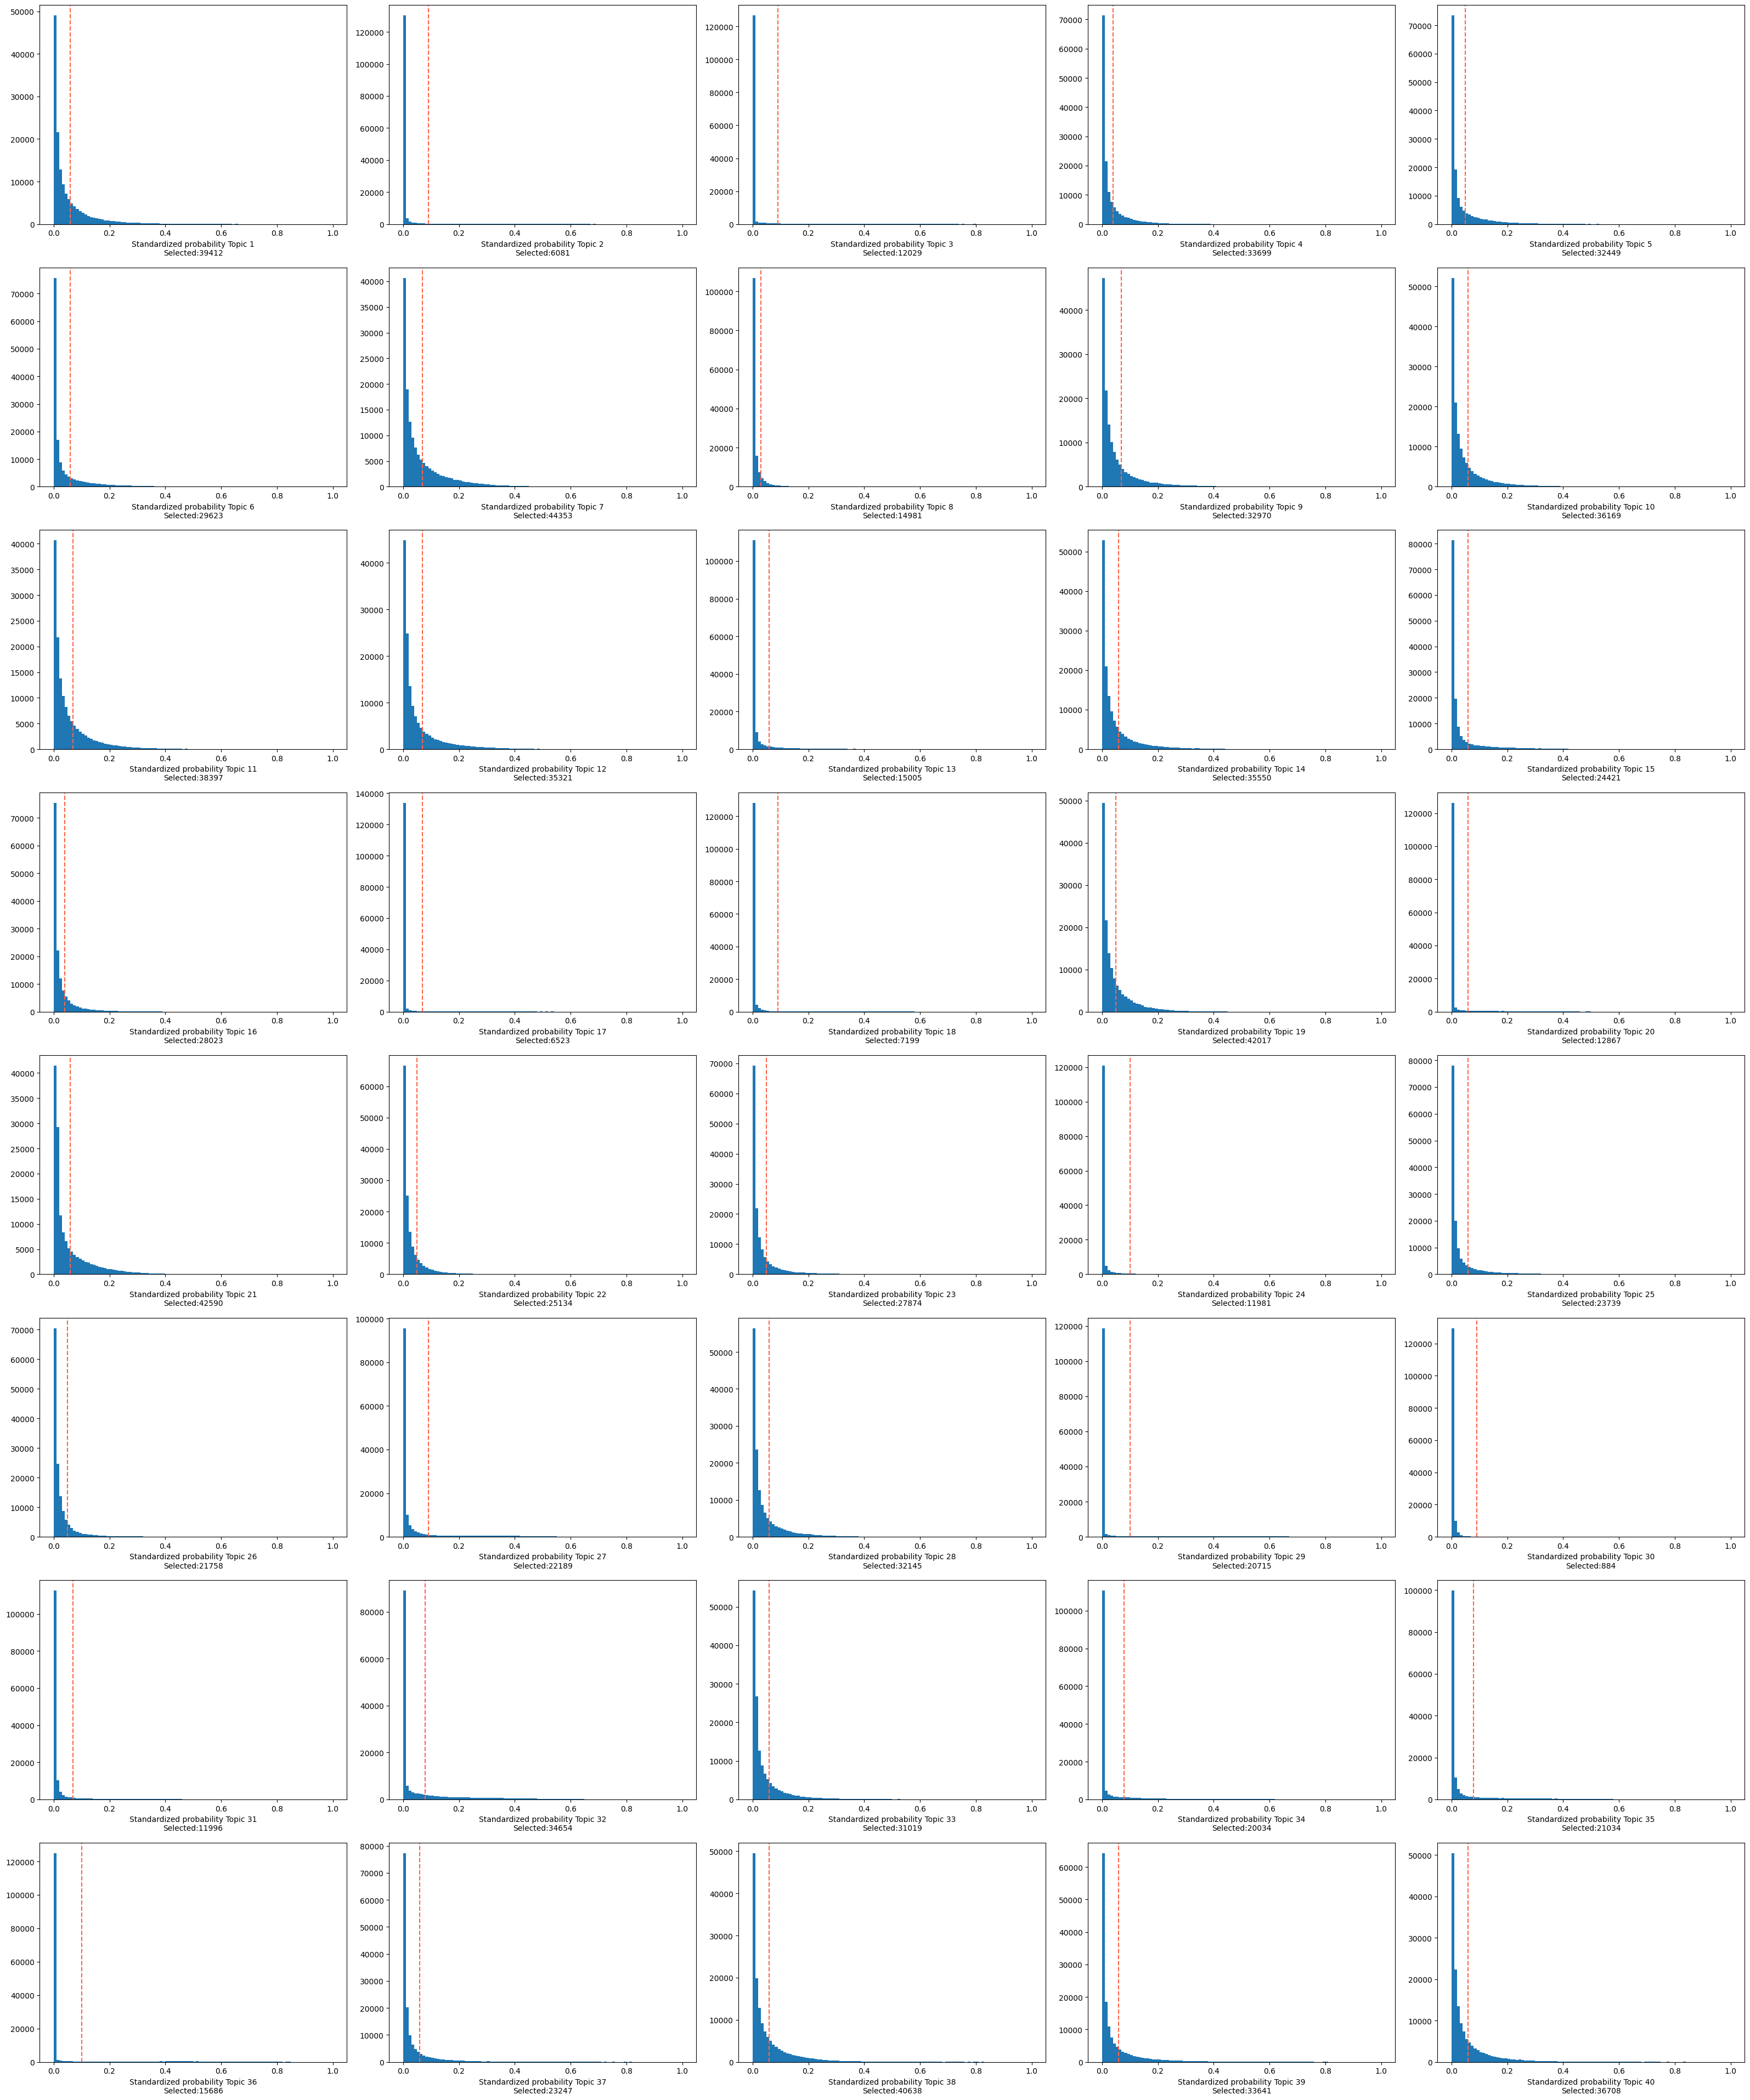

In [17]:
binarized_cell_topic = binarize_topics(
    cistopic_obj,
    target='cell',
    method='li',
    plot=True,
    num_columns=5, nbins=100)

In [18]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img

In [19]:
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

In [20]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

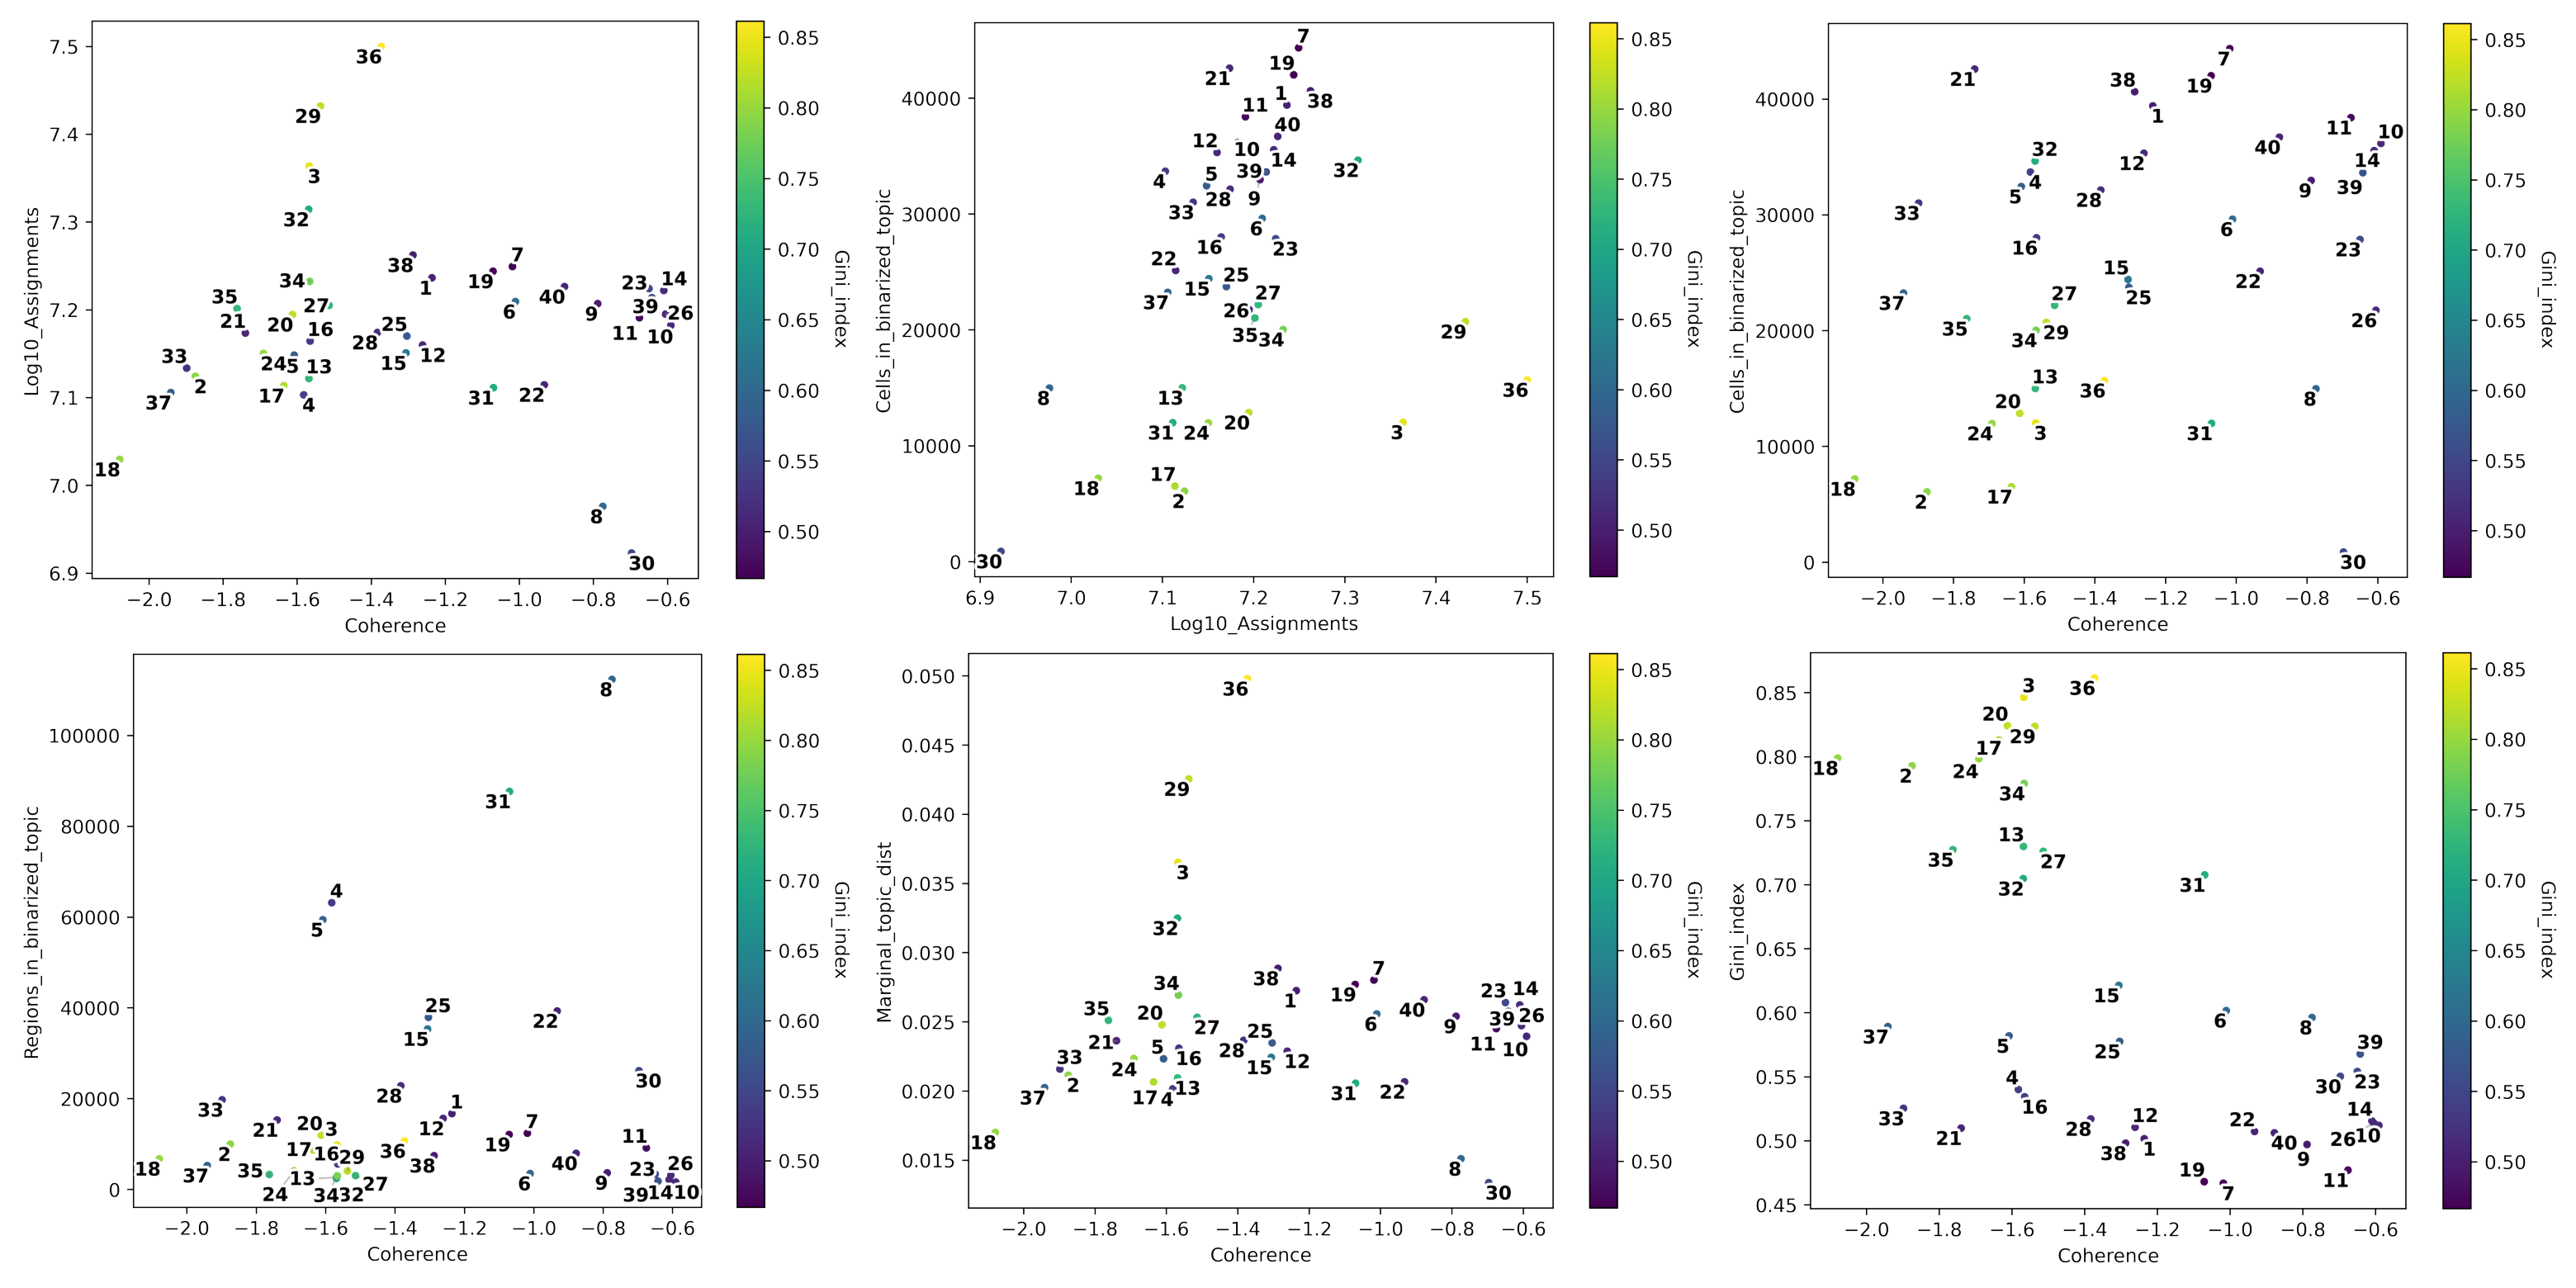

In [21]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()

In [22]:
topic_annot = topic_annotation(
    cistopic_obj,
    annot_var='main_cluster_annotation',
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr = 0.2
)

In [23]:
topic_annot

,main_cluster_annotation,Ratio_cells_in_topic,Ratio_group_in_population,is_general
Topic1,"T, NK",0.271386,0.587289,False
Topic2,"HSPC, pDC",0.041873,0.134274,False
Topic3,HSPC,0.08283,0.131389,False
Topic4,"T, NK",0.232047,0.587289,False
Topic5,"T, NK",0.223439,0.587289,False
Topic6,T,0.20398,0.523106,False
Topic7,"CD14 mono, NK, CD16 mono, B",0.305409,0.335583,False
Topic8,"HSPC, CD14 mono, DC, pDC, CD16 mono",0.103157,0.251031,False
Topic9,"T, NK, B",0.227027,0.746862,False
Topic10,"HSPC, B",0.249055,0.290962,False


In [24]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

# Differentially Accessible Regions (DARs)

In [3]:
cistopic_obj = pickle.load(open(os.path.join(out_dir, "cistopic_obj.pkl"), "rb"))

In [4]:
from pycisTopic.diff_features import (
    impute_accessibility,
    normalize_scores,
    find_highly_variable_features,
    find_diff_features
)
import numpy as np

In [5]:
imputed_acc_obj = impute_accessibility(
    cistopic_obj,
    selected_cells=None,
    selected_regions=None,
    scale_factor=10**6
)

2024-12-26 17:28:47,644 cisTopic     INFO     Imputing region accessibility
2024-12-26 17:28:47,645 cisTopic     INFO     Impute region accessibility for regions 0-20000
2024-12-26 17:29:02,301 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-12-26 17:29:17,018 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-12-26 17:29:31,741 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-12-26 17:29:46,419 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-12-26 17:30:01,212 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-12-26 17:30:16,071 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-12-26 17:30:30,755 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-12-26 17:30:45,585 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-12-26 17:31:00,442 cisTopic     

In [6]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2024-12-26 17:34:03,012 cisTopic     INFO     Normalizing imputed data
2024-12-26 17:38:16,909 cisTopic     INFO     Done!


In [ ]:
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp = 0.05,
    min_mean = 0.0125,
    max_mean = 3,
    max_disp = np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True
)

2024-12-26 17:39:33,364 cisTopic     INFO     Calculating mean
2024-12-26 17:40:25,880 cisTopic     INFO     Calculating variance


In [ ]:
len(variable_regions)

In [ ]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

We can now identify differentially accessible regions between groups. By default, this function will perform a Wilcoxon rank-sum test between each group using the specified variable and the rest.

Alternatively, specified contrast can be provided as a list with foreground and background groups (e.g. for group 1 versus group 2 and 3, and group 2 versus group 1 and 3: [[[‘Group_1’], [‘Group_2, ‘Group_3’]], [[‘Group_2’], [‘Group_1, ‘Group_3’]]]).

In [ ]:
markers_dict= find_diff_features(
    cistopic_obj,
    imputed_acc_obj,
    variable='main_cluster_annotation',
    var_features=variable_regions,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1.5),
    n_cpu=5,
    _temp_dir='/scratch/ramaiar1/DAR',
    split_pattern = '-'
)

In [ ]:
from pycisTopic.clust_vis import plot_imputed_features

In [ ]:
plot_imputed_features(
    cistopic_obj,
    reduction_name='UMAP',
    imputed_data=imputed_acc_objB
    features=[markers_dict[x].index.tolist()[0] for x in ['HSPC', 'B', 'T', 'CD14 mono']],
    scale=False,
    num_columns=4
)

In [ ]:
print("Number of DARs found:")
print("---------------------")
for x in markers_dict:
    print(f"  {x}: {len(markers_dict[x])}")

# Save region sets

In [ ]:
os.makedirs(os.path.join(out_dir, "region_sets"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_top_3k"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "DARs_cell_type"), exist_ok = True)

In [ ]:
from pycisTopic.utils import region_names_to_coordinates

In [ ]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [ ]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [ ]:
for cell_type in markers_dict:
    region_names_to_coordinates(
        markers_dict[cell_type].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "DARs_cell_type", f"{cell_type}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [ ]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)